In [116]:
import numpy as np
import pandas as pd

from random import randint
from tqdm.autonotebook import tqdm
from functools import partial

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ML algo
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression

In [132]:
class MLModels():
    model = None
    setting_title = None
    n_trials = 50
    rs_max = 2**32 - 1
    
    def __init__(self):
        self.training_accuracy = None
        self.test_accuracy = None
        self.training_std = None
        self.test_std = None
        
    def plot_test_train(self):
        plt.plot(self.setting, self.training_accuracy, label="training accuracy")
        plt.plot(self.setting, self.test_accuracy, label="test accuracy")
        plt.fill_between(self.setting, self.training_accuracy-self.training_std, self.training_accuracy+self.training_std, alpha=0.2)
        plt.fill_between(self.setting, self.test_accuracy-self.test_std, self.test_accuracy+self.test_std, alpha=0.2)
        plt.ylabel("Accuracy")
        plt.xlabel(self.setting_title)
        plt.legend()
        
    def calculate_accuracy(self, X, y):
        train_accuracies = []
        test_accuracies = []
        with tqdm(total=self.n_trials*len(self.setting)) as pb:
            for i in range(self.n_trials):
                X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=randint(0, self.rs_max))
                pb.set_description(f'Iter: {i + 1}')
                training_accuracy = []
                test_accuracy = []
                for s in self.setting:
                    # build the model
                    clf = self.model(**{self.setting_title: s})
                    clf.fit(X_train, y_train)
                    # record training set accuracy
                    training_accuracy.append(clf.score(X_train, y_train))
                    # record generalization accuracy
                    test_accuracy.append(clf.score(X_test, y_test))
                    pb.update(1)
                train_accuracies.append(training_accuracy)
                test_accuracies.append(test_accuracy)
            
        self.training_accuracy = np.mean(train_accuracies, axis=0)
        self.test_accuracy = np.mean(test_accuracies, axis=0)
        self.training_std = np.std(train_accuracies, axis=0)
        self.test_std = np.std(test_accuracies, axis=0)

class KNNRegressor(MLModels):
    model = partial(KNeighborsRegressor, algorithm='kd_tree')
    setting_title = 'n_neighbors'
    
    def __init__(self, neighbor_setting):
        super().__init__()
        self.setting = neighbor_setting
        
class LinearRegressor(MLModels):
    model = None
    setting_title = 'alpha'
    
    def __init__(self, alpha_runs):
        super().__init__()
        self.setting = alpha_runs
        
class LassoRegressor(LinearRegressor):
    model = partial(Lasso, max_iter=10000)
    
class RidgeRegressor(LinearRegressor):
    model = Ridge

In [60]:
model = KNeighborsRegressor(n_neighbors=10, algorithm='kd_tree')
model.fit(tts[0], tts[2])
model.score(tts[1], tts[3])

0.9535798964249043

In [3]:
df = pd.read_excel('parkinsons_updrs.xlsx')

In [4]:
targets = df.loc[:, 'Target']
df.drop('Target', axis=1, inplace=True)

In [5]:
tts = train_test_split(df, targets, test_size=0.25)

In [133]:
knncs = KNNRegressor(range(1, 10, 1))
knncs.n_trials = 5

In [134]:
knncs.calculate_accuracy(df, targets)

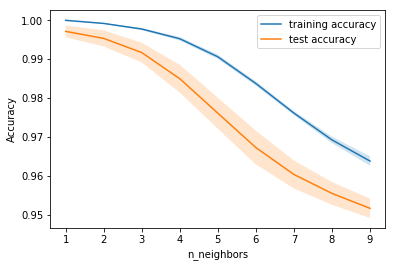

In [135]:
knncs.plot_test_train()

In [89]:
alpha_ridge = [1e-12, 1e-10, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20]

In [94]:
lr = LassoRegressor(alpha_ridge)

In [95]:
lr.calculate_accuracy(*tts)

/Users/edavid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22661.00967394801, tolerance: 50.768572987787465
  positive)
/Users/edavid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22639.396473687637, tolerance: 50.768572987787465
  positive)


/Users/edavid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20773.17337698409, tolerance: 50.768572987787465
  positive)


In [96]:
lr.test_std

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

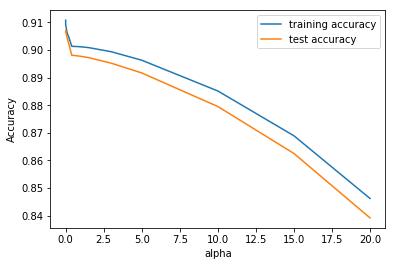

In [97]:
lr.plot_test_train()

In [100]:
rr = RidgeRegressor(alpha_ridge)

In [101]:
rr.calculate_accuracy(*tts)

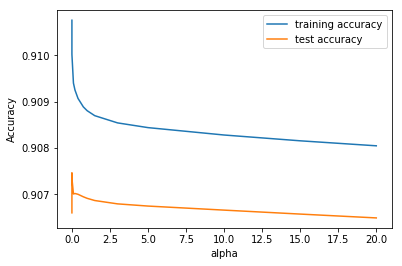

In [102]:
rr.plot_test_train()